# NCCL tests

Results from NCCL benchmarks.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
# Constants and conversions
B2KiB = 1024
Gb2MB = 125

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in bytes.

In [4]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Benchmarks

By default following benchmarks are executed:

- Sendrecv
- Gather
- Scatter
- Reduce
- AllGather
- AllReduce

Each benchmark runs in two modes:

- in-place: Same buffers are used for input and output.
- out-of-place: Output buffers are different from input ones.

Each benchmark reports two types of bandwidths namely, algorithmic bandwidth (`algbw`) and bus bandwidth (`busbw`). More information about these bandwidths can be found [here](https://github.com/NVIDIA/nccl-tests/blob/master/doc/PERFORMANCE.md).

All benchmarks are run for range of message sizes that can be configured at runtime.

## Maximum bandwidths for different primitives in GB/s

The table shows the maximum bandwidths obtained amongst all message sizes for different communication primitives.

In [5]:
test = 'NcclPerfTest_'
max_bw_comms = {}
for perf_name, perf_pat in [('SendRecv', 'sendrecv'), 
                            ('Gather', 'gather'), 
                            ('Scatter', 'scatter'),
                            ('Reduce', 'reduce'),
                            ('AllGather', 'all_gather'),
                            ('AllReduce', 'all_reduce')]:
    df = modules.utils.tabulate_last_perf(test=test + perf_pat,
                                          root=PERFLOG_DIR,
                                          extras=[])
    for bw_type in ['algbw', 'busbw']:
        data_bw = df.filter(regex=(bw_type), axis=0)
        for place in ['in', 'out']:
            data_pl = data_bw.filter(regex=(place), axis=0)
            for c in data_pl.columns:
                max_bw = data_pl.max(axis=0).values[0]
                system, partition, _ = c.split(':')
                if c not in max_bw_comms.keys():
                    max_bw_comms[c] = {}
                if (perf_name, bw_type, place) not in max_bw_comms[c].keys():
                    max_bw_comms[c][(perf_name, bw_type, place)] = {}
                max_bw_comms[c][(perf_name, bw_type, place)] = max_bw

result = pd.DataFrame.from_dict(max_bw_comms, orient='columns')
result.index = pd.MultiIndex.from_tuples(result.index)
display(pd.DataFrame(max_bw_comms))

cscs-daint:daint-icc21-impi21-ib-umod-gpu:nccl-test  \
SendRecv  algbw in                                              228.51     
                out                                            4739.50     
          busbw in                                              228.51     
                out                                            4739.50     
Gather    algbw in                                              228.67     
                out                                            4702.12     
          busbw in                                                0.00     
                out                                               0.00     
Scatter   algbw in                                              228.49     
                out                                            4717.92     
          busbw in                                                0.00     
                out                                               0.00     
Reduce    algbw in                                              260.56     
                out                                          278402.26     
          busbw in                                              260.56     
                out                                          278402.26     
AllGather algbw in                                              260.26     
                out                                          278200.29     
          busbw in                                                0.00     
                out                                               0.00     
AllReduce algbw in                                              260.63     
                out                                          277825.97     
          busbw in                                                0.00     
                out                                               0.00     

                     juwels-booster:booster-gcc9-ompi4-ib-umod-nvgpu:nccl-test  
SendRecv  algbw in                                              228.51          
                out                                            4739.50          
          busbw in                                              228.51          
                out                                            4739.50          
Gather    algbw in                                              228.67          
                out                                            4702.12          
          busbw in                                                0.00          
                out                                               0.00          
Scatter   algbw in                                              228.49          
                out                                            4717.92          
          busbw in                                                0.00          
                out                                               0.00          
Reduce    algbw in                                              260.56          
                out                                          278402.26          
          busbw in                                              260.56          
                out                                          278402.26          
AllGather algbw in                                              260.26          
                out                                          278200.29          
          busbw in                                                0.00          
                out                                               0.00          
AllReduce algbw in                                              260.63          
                out                                          277825.97          
          busbw in                                                0.00          
                out                                               0.00

## Results of different communication primitives

The plots show bandwidths for different benchmarks as a function of message size. Results are for the most-recent test on each system/partition/environment combination.

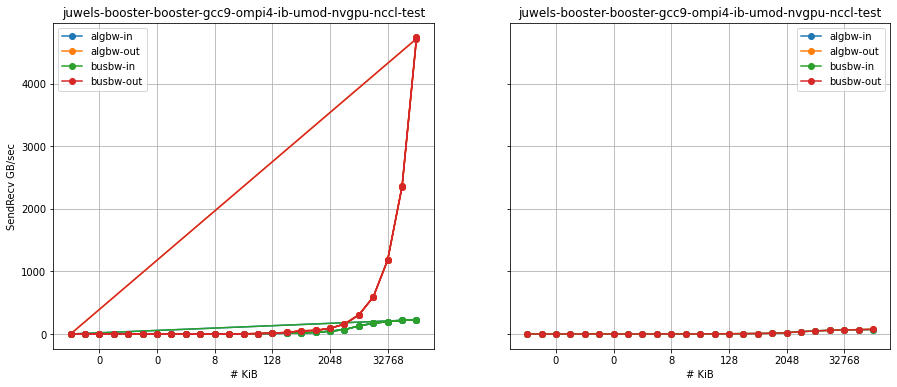

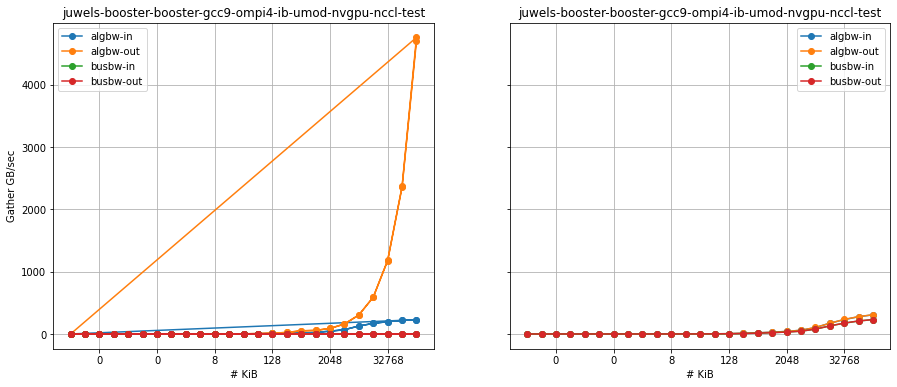

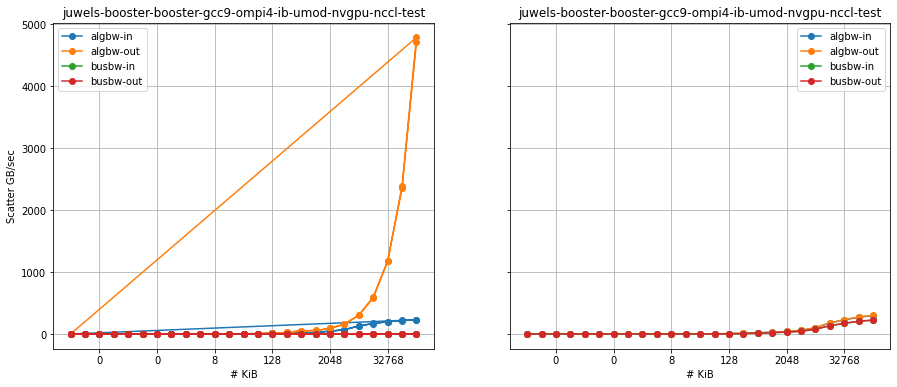

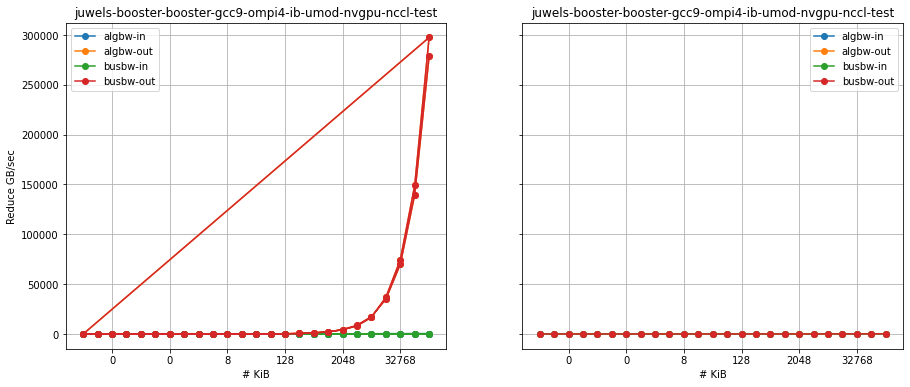

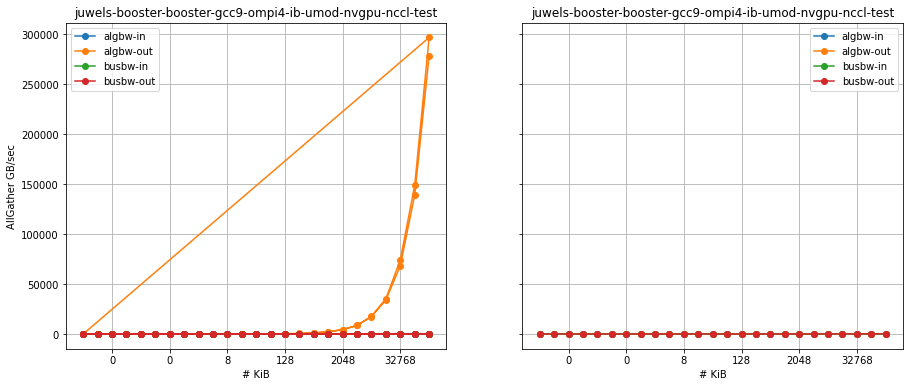

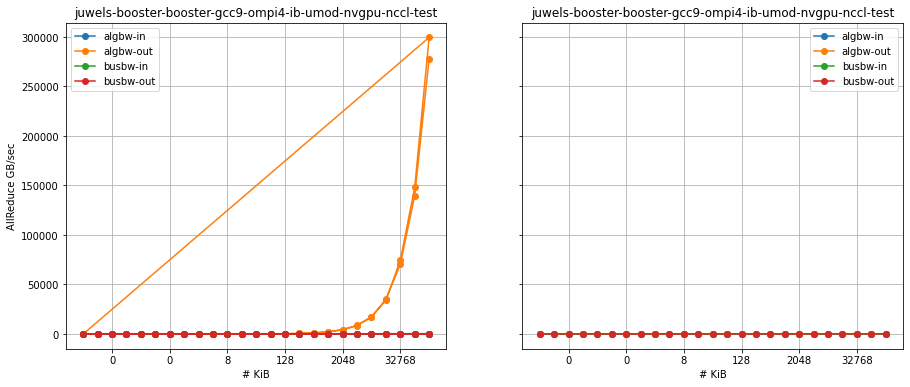

In [11]:
test='NcclPerfTest_'
for perf_name, perf_pat in [('SendRecv', 'sendrecv'), 
                            ('Gather', 'gather'), 
                            ('Scatter', 'scatter'),
                            ('Reduce', 'reduce'),
                            ('AllGather', 'all_gather'),
                            ('AllReduce', 'all_reduce')]:
    perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=[], test=test + perf_pat, last=True)
    if perf_records is None:
        print('%s: no performance logs found' % test)
    nsystems = perf_records.groupby(['sysname', 'partition', 'environ']).ngroups
    fig, axes = plt.subplots(nrows=1, ncols=nsystems, sharey=True, figsize=(15, 6))
    if nsystems == 1:
        axes = [axes]
    for iplot, (spe, data) in enumerate(perf_records.groupby(['sysname', 'partition', 'environ'])):
        for (bw_name, bw, place, unit) in [('Alg. BW', 'algbw', 'in', ' GB/sec'),
                                           ('Alg. BW', 'algbw', 'out', ' GB/sec'),
                                           ('Bus BW', 'busbw', 'in', ' GB/sec'),
                                           ('Bus BW', 'busbw', 'out', ' GB/sec'),]:
            c_df = data.loc[
            data.perf_var.str.contains(bw) & data.perf_var.str.contains(place), :
            ]
            c_df['#bytes'] = c_df.perf_var.apply(lambda x: int(x.replace(bw, '').replace(place, '').replace('_', '')) / B2KiB)
            c_df.plot(ax=axes[iplot], x='#bytes', y='perf_value', style=['o-'], label='-'.join([bw, place]), legend=None)


    for ax in axes:
        ax.set_xticks(c_df['#bytes'])
        ax.set_xticklabels(c_df['#bytes'])
        ax.set_title('-'.join(spe) )
        ax.set_xlabel('# KiB')
        ax.set_ylabel(perf_name + unit)
        ax.set_xscale('log', base=2)
        if 'lat' in perf_name:
            ax.set_yscale('log', base=10)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        handles, labels = ax.get_legend_handles_labels()
        ax.grid(True, which='both')
        ax.legend()